# Create dataframes for image loader

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import os

import torch
from skimage import io, transform
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from torchvision import datasets
from torchvision.transforms import ToTensor
import cv2
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torchvision import models
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryAccuracy, BinaryROC, BinaryAUROC
import PIL
from PIL import Image

# visualisation
import seaborn as sns

# helpers
from tqdm import tqdm
import time
import copy
import gc
from enum import Enum

import warnings
warnings.filterwarnings('ignore')

metadata_list=['calc_case_description_test_set','calc_case_description_train_set']
#'mass_case_description_test_set','mass_case_description_train_set',
df_list=[]
for j in range(len(metadata_list)):
    print (metadata_list[j])
    df=pd.read_csv('C:/Users/marcb/Downloads/'+metadata_list[j]+'.csv')
    print (len(df))
    
    fname=[]
    df=df.rename(columns={"file path": "filename","pathology":"class", 'image file path':'filename'})
    for k in range(len(df)):
        fname.append(df['filename'].loc[k])
        if k>0:
            if fname[k] == fname[k-1]:
                df.drop(k, inplace=True)
    print ('df length after removal of repeats: ', len(df))
    
    for i in range(len(df)):
        df.filename.iloc[i]='C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/v6_lowclahe_highkernel/'+df.filename.iloc[i].rsplit('/',3)[0]+'/1-1.jpg'
        #df.filename[i]='F:/CBIS_DDSM_redo/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM-png/'+df.filename[i].rsplit('/',3)[0]+'/1-1.png'
        if 'MALIGNANT' in df['class'].iloc[i]:
            df['class'].iloc[i]=1
        else:
            df['class'].iloc[i]=0
    df_list.append(df)
#df_list
# df_mass_test=df_list[0]
# df_mass_train=df_list[1]
df_calc_test=df_list[0]
df_calc_train=df_list[1]

# filenames=[]
# labels=[]
# for i in range(len(df_mass_train)):
#     filenames.append(df_mass_train.filename[i])
#     labels.append(df_mass_train['class'][i])

# filenames_test=[]
# labels_test=[]
# for i in range(len(df_mass_test)):
#     filenames_test.append(df_mass_test.filename[i])
#     labels_test.append(df_mass_test['class'][i])
    
filenames_calc=[]
labels_calc=[]
for i in range(len(df_calc_train)):
    filenames_calc.append(df_calc_train.filename.iloc[i])
    labels_calc.append(df_calc_train['class'].iloc[i])

filenames_test_calc=[]
labels_test_calc=[]
for i in range(len(df_calc_test)):
    filenames_test_calc.append(df_calc_test.filename.iloc[i])
    labels_test_calc.append(df_calc_test['class'].iloc[i])

calc_case_description_test_set
326
df length after removal of repeats:  286
calc_case_description_train_set
1546
df length after removal of repeats:  1227


In [2]:
df

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,class,subtlety,filename,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,1,3,C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,1,3,C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,0,4,C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,0,4,C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,0,3,C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,P_02566,2,RIGHT,MLO,1,calcification,AMORPHOUS-PLEOMORPHIC,SEGMENTAL,5,1,5,C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/...,Calc-Training_P_02566_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_02566_RIGHT_MLO_1/1.3.6.1.4.1....
1542,P_02572,2,LEFT,CC,1,calcification,AMORPHOUS,CLUSTERED,0,1,2,C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/...,Calc-Training_P_02572_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_02572_LEFT_CC_1/1.3.6.1.4.1.95...
1543,P_02572,2,LEFT,MLO,1,calcification,AMORPHOUS,CLUSTERED,0,1,2,C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/...,Calc-Training_P_02572_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_02572_LEFT_MLO_1/1.3.6.1.4.1.9...
1544,P_02584,1,LEFT,CC,1,calcification,PLEOMORPHIC,SEGMENTAL,0,0,4,C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/...,Calc-Training_P_02584_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_02584_LEFT_CC_1/1.3.6.1.4.1.95...


In [3]:

import torchvision

#plt.ion()   # interactive mode

##########################################
##### HERE ARE THE AUGMENTATIONS!!! ######
##########################################

augmentator = transforms.Compose([
    # input for augmentator is always PIL image
    transforms.ToPILImage(),
    transforms.RandomAdjustSharpness(.2, p=0.5),
    transforms.ColorJitter(brightness=.2,contrast=.2),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(6),
    #transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 3)),
#    transforms.RandomAutocontrast(),
    transforms.ToTensor(), # return it as a tensor and transforms it to [0, 1]
])

small_aug = transforms.Compose([
    # input for augmentator is always PIL image
    transforms.ToPILImage(),
    
    transforms.ToTensor(), # return it as a tensor and transforms it to [0, 1]
])

def show_landmarks(image, label):
    """Show image with landmarks"""
    plt.imshow(image)
    if label==0:
        classif='Benign'
    else:
        classif='Malignant'
    print ('Class: ',classif)
    plt.pause(0.001)  # pause a bit so that plots are updated

class CBISDataset(Dataset):
    """CBIS-DDSM dataset."""

    def __init__(self, labels, filenames, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = labels
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        fname = self.filenames[idx]
        image = torchvision.io.read_image(fname)#, torchvision.io.ImageReadMode.RGB)
        image = image.repeat(3, 1, 1)
        label = self.labels[idx]    
        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
#dataset = CBISDataset(labels_calc,filenames_calc,transform=augmentator)

# val_pct = 0.2
# val_size = int(val_pct * len(dataset))
# train_size = len(dataset) - val_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset=CBISDataset(labels_calc,filenames_calc,transform=augmentator)
val_dataset = CBISDataset(labels_test_calc,filenames_test_calc, transform=small_aug)
val_size =  len(val_dataset)
train_size = len(train_dataset)

In [5]:
print (val_size, len(labels_test_calc),train_size, len(labels_calc))
for i in range(len(labels_test_calc)):
    if labels_test_calc[i] == 1:
        print (filenames_test_calc[i])

286 286 1227 1227
C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/v6_lowclahe_highkernel/Calc-Test_P_00127_RIGHT_CC/1-1.jpg
C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/v6_lowclahe_highkernel/Calc-Test_P_00127_RIGHT_MLO/1-1.jpg
C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/v6_lowclahe_highkernel/Calc-Test_P_00150_RIGHT_MLO/1-1.jpg
C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/v6_lowclahe_highkernel/Calc-Test_P_00164_RIGHT_CC/1-1.jpg
C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/v6_lowclahe_highkernel/Calc-Test_P_00202_RIGHT_CC/1-1.jpg
C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/v6_lowclahe_highkernel/Calc-Test_P_00202_RIGHT_MLO/1-1.jpg
C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/v6_lowclahe_highkernel/Calc-Test_P_00244_RIGHT_MLO/1-1.jpg
C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/v6_lowclahe_highkernel/Calc-Test_P_00299_LEFT_MLO/1-1.jpg
C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/v6_lowclahe_highkernel/Calc-Test_P_00299_RIGHT_CC/1-1.jpg
C:/Users/marcb/Desktop/CBIS-DDSM-preproces

In [6]:
batch_size = 14
#try pin memory = False

# Create data loaders.
#train_dataloader = DataLoader(dataset, batch_size=batch_size,
#                        shuffle=True)#, num_workers=0)
#test_dataloader = DataLoader(test_data, batch_size=batch_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, pin_memory = True,num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle = True, pin_memory = True,num_workers=0)


for X, y in val_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    #img=X
    break

Shape of X [N, C, H, W]: torch.Size([14, 3, 500, 300])
Shape of y: torch.Size([14]) torch.int64


tensor([[[[0.7098, 0.7529, 0.7176,  ..., 0.0157, 0.0157, 0.0157],
          [0.6902, 0.7176, 0.7294,  ..., 0.0157, 0.0157, 0.0157],
          [0.7176, 0.7020, 0.6863,  ..., 0.0157, 0.0157, 0.0157],
          ...,
          [0.1686, 0.1451, 0.1373,  ..., 0.0157, 0.0157, 0.0157],
          [0.1647, 0.1451, 0.1373,  ..., 0.0157, 0.0157, 0.0157],
          [0.1647, 0.1451, 0.1373,  ..., 0.0157, 0.0157, 0.0157]],

         [[0.7098, 0.7529, 0.7176,  ..., 0.0157, 0.0157, 0.0157],
          [0.6902, 0.7176, 0.7294,  ..., 0.0157, 0.0157, 0.0157],
          [0.7176, 0.7020, 0.6863,  ..., 0.0157, 0.0157, 0.0157],
          ...,
          [0.1686, 0.1451, 0.1373,  ..., 0.0157, 0.0157, 0.0157],
          [0.1647, 0.1451, 0.1373,  ..., 0.0157, 0.0157, 0.0157],
          [0.1647, 0.1451, 0.1373,  ..., 0.0157, 0.0157, 0.0157]],

         [[0.7098, 0.7529, 0.7176,  ..., 0.0157, 0.0157, 0.0157],
          [0.6902, 0.7176, 0.7294,  ..., 0.0157, 0.0157, 0.0157],
          [0.7176, 0.7020, 0.6863,  ..., 0

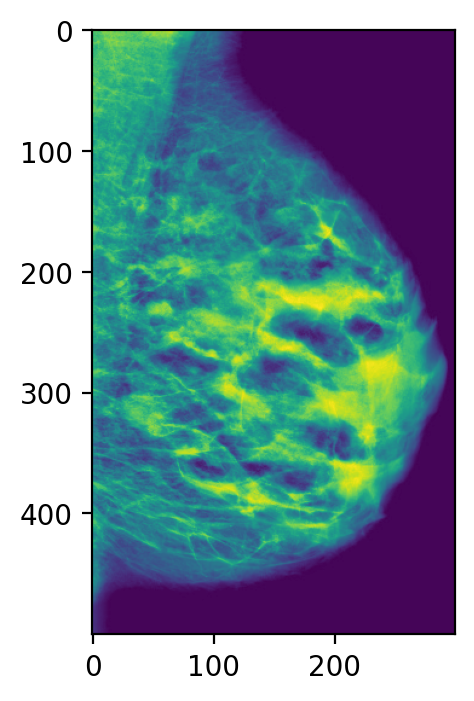

In [7]:
plt.figure(figsize=(4,4),dpi=200)
plt.imshow(X[0,:,:,:].permute(1, 2, 0)[:,:,0])
X.dtype
# torch.min(X[0,0,:,:])
#torch.max(X[0])
X

There are 10.0 negative and 4.0 positive samples in this batch.


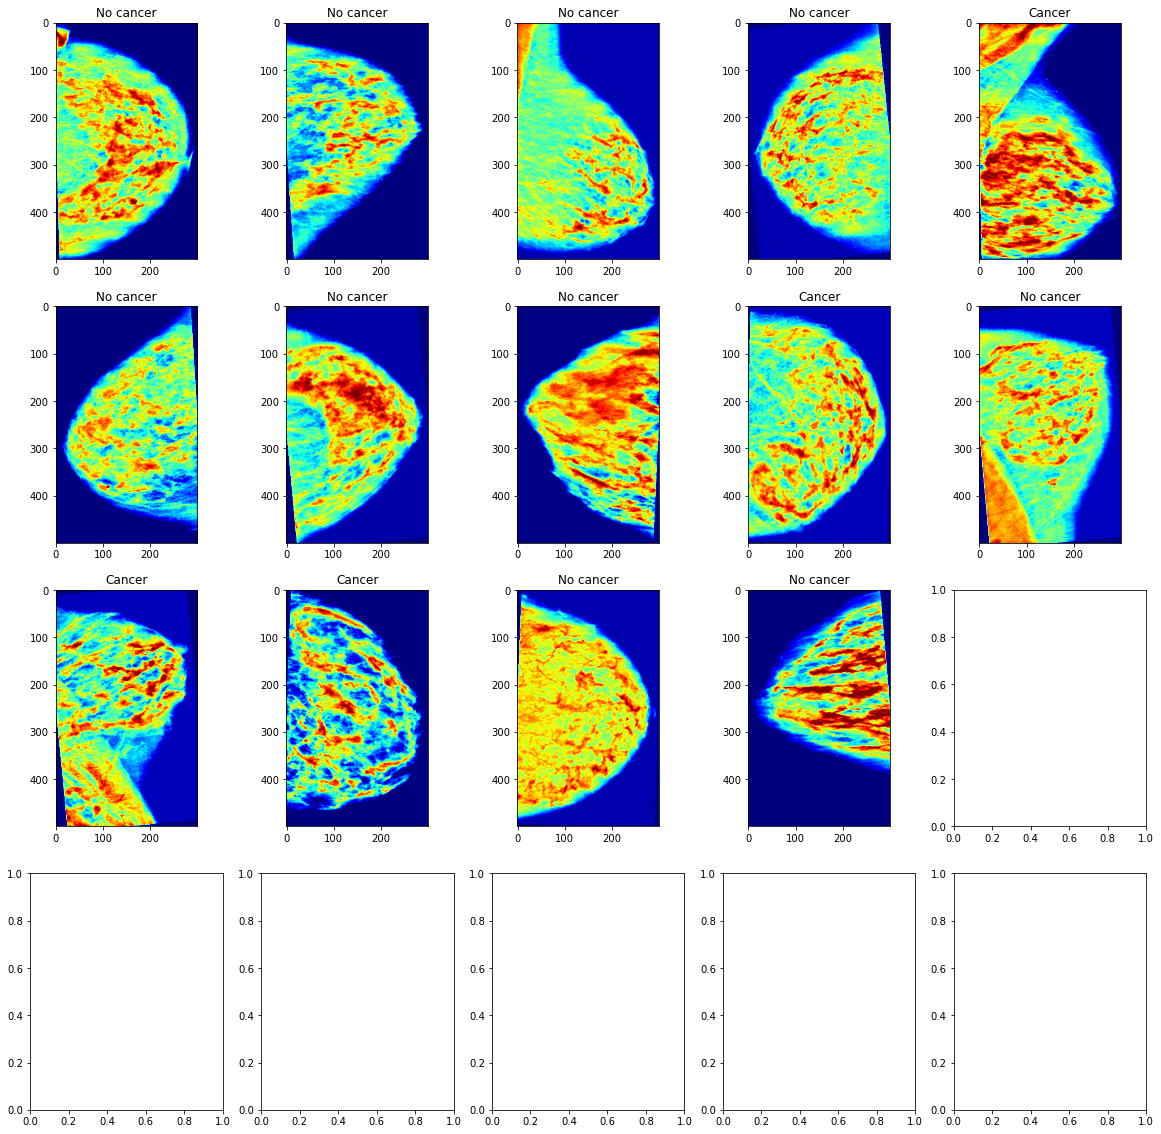

In [8]:
rows = 4
cols = 5
plt.subplots(rows, cols, figsize = (20, 20))

batch_imgs, batch_labels = next(iter(train_dataloader))
i = 0
for img in batch_imgs:
    
    if i >= rows*cols:
        break
    plt.subplot(rows, cols, i + 1)
    plt.title("Cancer" if batch_labels[i] == 1 else "No cancer")
    plt.imshow(img.permute(1, 2, 0)[:,:,0], cmap='jet')

    i += 1

labels_count = np.zeros(2)
for l in batch_labels:
    labels_count[l] += 1 
    
print(f'There are {labels_count[0]} negative and {labels_count[1]} positive samples in this batch.')

In [9]:

    
    
# create class for earlystopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = np.inf

    def early_stop(self, loss):
        if loss <= self.min_loss:
            self.min_loss = loss
            self.counter = 0
        elif loss > (self.min_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    
def BCELoss_class_weighted(weights):
    """
    weights[0] is weight for class 0 (negative class)
    weights[1] is weight for class 1 (positive class)
    """
    def loss(y_pred, target):
        y_pred = torch.clamp(y_pred,min=1e-7,max=1-1e-7) # for numerical stability
        bce = - weights[1] * target * torch.log(y_pred) - (1 - target) * weights[0] * torch.log(1 - y_pred)
        return torch.mean(bce)

    return loss

def find_optim_thres(fpr, tpr, thresholds):
    optim_thres = thresholds[0]
    inx = 0
    min_dist = 1.0
    for i in range(len(fpr)):
        dist = np.linalg.norm(np.array([0.0, 1.0]) - np.array([fpr[i], tpr[i]]))
        if dist < min_dist:
            min_dist = dist
            optim_thres = thresholds[i]
            inx = i
            
    return optim_thres, inx

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    metricf1 = BinaryF1Score()
    precision = BinaryPrecision()
    recall = BinaryRecall()
    accuracy = BinaryAccuracy()
    roc = BinaryROC()
    auc = BinaryAUROC()
    best_model_wts = model.state_dict()
    stop_count = 0
    best_f1 = -1.0
    train_metrics = {'loss' : [], 'acc' : [], 'f1': [], 'precision': [], 'recall': [], 'auc': []}
    val_metrics = {'loss' : [], 'acc' : [], 'f1': [], 'precision': [], 'recall': [], 'auc': []}
    # inital threshold for first epoch, it will change afterwards
    threshold = 0.5
    print('Starting training...')
    print('-' * 20)
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # empty 'all' tensors for saving
            # for calculating aoc at the end of epoch, and for calculating new threshold
            all_outputs = torch.Tensor([])
            all_labels = torch.Tensor([])
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            n_samples = 0
            n_correct = 0
            running_f1 = 0.0
            # Iterate over data.
            print(f'{phase} for epoch {epoch + 1}')
            for inputs, labels in tqdm(dataloaders[phase]):
                labels = torch.unsqueeze(torch.tensor(labels), 1).to(dtype=torch.float)               
                #labels=torch.tensor(labels)
                inputs = inputs.float()
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = (outputs > threshold).double()
                    #print(all_outputs)
                    #print(outputs)
                    # concatenating all outputs and labels for calculation aoc and new threshold
                    all_outputs = torch.cat((all_outputs, outputs.to('cpu')))
                    all_labels = torch.cat((all_labels, labels.to('cpu')))                  
                    #print(labels)
                    # _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
#                         scheduler.step()
                # statistics
                # n_samples += labels.size(0)
                running_loss += loss.item()
                # n_correct += (preds == labels).sum().item()
                #print(f'Current loss is {loss.item()}')
                # collect any unused memmory
                gc.collect()
                torch.cuda.empty_cache()           
            # statistics
            epoch_loss = running_loss / len(dataloaders[phase])            
            # find true positive and false positive rates for ROC curve
            #print ('outputs: ', all_outputs, 'labels', all_labels)
            all_labels=all_labels.to(dtype=torch.long)
            fpr, tpr, thresholds = roc(all_outputs, all_labels)
            epoch_auc = auc(all_outputs, all_labels)
            # find new threshold
            threshold, _ = find_optim_thres(fpr, tpr, thresholds)
            print(f'New threshold is {threshold}')
            # calculate metrics using new optimized threshold
            epoch_f1 = metricf1(all_outputs > threshold, all_labels)
            epoch_acc = accuracy(all_outputs > threshold, all_labels)
            epoch_precision = precision(all_outputs > threshold, all_labels)
            epoch_recall = recall(all_outputs > threshold, all_labels)
            print(f'{phase} F1 is {epoch_f1}')            
            # save all of the statistics for latter analysis
            if phase == 'train':
                #scheduler.step()
                train_metrics['loss'].append(epoch_loss)
                train_metrics['acc'].append(epoch_acc)
                train_metrics['f1'].append(epoch_f1)
                train_metrics['precision'].append(epoch_precision)
                train_metrics['recall'].append(epoch_recall)
                train_metrics['auc'].append(epoch_auc)
            else:
                val_metrics['loss'].append(epoch_loss)
                val_metrics['acc'].append(epoch_acc)
                val_metrics['f1'].append(epoch_f1)
                val_metrics['precision'].append(epoch_precision)
                val_metrics['recall'].append(epoch_recall)
                val_metrics['auc'].append(epoch_auc)

            # deep copy the model
            if phase == 'val' and epoch_auc > best_f1:
                best_f1 = epoch_auc
                best_model_wts = model.state_dict()
                checkpoint['threshold'] = threshold
                torch.save(checkpoint, 'checkpoint.pth')
               
        # cant be formated in string
        tr_loss, tr_acc, tr_f1, tr_prec, tr_rec, tr_auc = train_metrics['loss'][-1], train_metrics['acc'][-1],  train_metrics['f1'][-1], train_metrics['precision'][-1], train_metrics['recall'][-1], train_metrics['auc'][-1]
        val_loss, val_acc, val_f1, val_prec, val_rec, val_auc = val_metrics['loss'][-1], val_metrics['acc'][-1], val_metrics['f1'][-1], val_metrics['precision'][-1], val_metrics['recall'][-1], val_metrics['auc'][-1]
        lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch + 1}/{num_epochs}, learning rate: {lr}')
        print(f'Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}, Train f1: {tr_f1:.4f}, Train Precision: {tr_prec:.4f}, Train Recall: {tr_rec:.4f}, Train AUC: {tr_auc:.4f}')
        print(f'Valitadion Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}, Vall f1: {val_f1:.4f}, Val Precision: {val_prec:.4f}, Val Recall: {val_rec:.4f}, Val AUC: {val_auc:.4f}')       
#         if epoch == 0:
#             val_f1_best=val_f1
#         else:
#             if val_f1 > val_f1_best:
#                 val_f1_best=val_f1
#                 stop_count = 0
#             else:
#                 stop_count = stop_count + 1
        
#         if stop_count == 80:
#             break
                
#         if earlystoper.early_stop(val_f1):
#             break       
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val auc: {best_f1:4f}')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_metrics, val_metrics

In [13]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    
# model = CNN()
# model.to(device)
model=my_resnet50(weights="IMAGENET1K_V2")
#model=my_resnext50_32x4d(weights="IMAGENET1K_V2")
model.to(device)

# defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=1e-6, max_lr=4e-6,step_size_up = 20, cycle_momentum =False)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=4e-5, steps_per_epoch=train_size, epochs=20)

#scheduler = StepLR(optimizer, step_size=20, gamma=0.8)
scheduler=None

# defining the loss function
# Binary cross entropy is chosen because it is the classification problem
# the weight should be smaller if class count is higher
neg=0
pos=0
# for label in labels:
#     if label==1:
#         pos=pos+1
#     else:
#         neg=neg+1
w_pos = 2
w_neg = 1
print(f"Class weight for negative class: {w_neg}, and for positive {w_pos}")
#criterion = BCELoss_class_weighted(weights = [w_neg, w_pos])
criterion = nn.BCELoss()
# define early stopping
# earlystoper = EarlyStopper(patience = 30)

checkpoint = {'model': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
             'threshold' : 0.5}

dataloaders = {'train' : train_dataloader, 'val' : val_dataloader}
dataset_sizes = {'train': train_size, 'val' : val_size}

Class weight for negative class: 1, and for positive 2


In [ ]:
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=6e-7, max_lr=6e-6,step_size_up = 100, cycle_momentum =False)
# earlystoper = EarlyStopper(patience = 50)
#optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
#optimizer = torch.optim.Adam(model.parameters(), lr=4e-5)

model, train_metrics, val_metrics = train_model(model, criterion, optimizer, scheduler, num_epochs=30)

Starting training...
--------------------
train for epoch 1


100%|██████████| 88/88 [00:40<00:00,  2.17it/s]


New threshold is 0.4546869993209839
train F1 is 0.525547444820404
val for epoch 1


100%|██████████| 21/21 [00:05<00:00,  3.99it/s]


New threshold is 0.4062011241912842
val F1 is 0.5512367486953735
Epoch 1/30, learning rate: 8e-05
Train Loss: 0.6733, Train Acc: 0.5762, Train f1: 0.5255, Train Precision: 0.4890, Train Recall: 0.5680, Train AUC: 0.5980
Valitadion Loss: 0.6610, Validation Acc: 0.5559, Vall f1: 0.5512, Val Precision: 0.4756, Val Recall: 0.6555, Val AUC: 0.6037
train for epoch 2


100%|██████████| 88/88 [00:36<00:00,  2.43it/s]


New threshold is 0.42325320839881897
train F1 is 0.5862966179847717
val for epoch 2


100%|██████████| 21/21 [00:04<00:00,  4.68it/s]


New threshold is 0.31918972730636597
val F1 is 0.5600000023841858
Epoch 2/30, learning rate: 8e-05
Train Loss: 0.6450, Train Acc: 0.6112, Train f1: 0.5863, Train Precision: 0.5232, Train Recall: 0.6667, Train AUC: 0.6524
Valitadion Loss: 0.6777, Validation Acc: 0.5769, Vall f1: 0.5600, Val Precision: 0.4936, Val Recall: 0.6471, Val AUC: 0.5965
train for epoch 3


100%|██████████| 88/88 [00:35<00:00,  2.45it/s]


New threshold is 0.4211607873439789
train F1 is 0.5808757543563843
val for epoch 3


100%|██████████| 21/21 [00:04<00:00,  4.82it/s]


New threshold is 0.5767757892608643
val F1 is 0.546875
Epoch 3/30, learning rate: 8e-05
Train Loss: 0.6422, Train Acc: 0.6178, Train f1: 0.5809, Train Precision: 0.5310, Train Recall: 0.6410, Train AUC: 0.6617
Valitadion Loss: 0.7121, Validation Acc: 0.5944, Vall f1: 0.5469, Val Precision: 0.5109, Val Recall: 0.5882, Val AUC: 0.6218
train for epoch 4


100%|██████████| 88/88 [00:35<00:00,  2.45it/s]


New threshold is 0.44550737738609314
train F1 is 0.5911237001419067
val for epoch 4


100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


New threshold is 0.5327040553092957
val F1 is 0.4913793206214905
Epoch 4/30, learning rate: 8e-05
Train Loss: 0.6299, Train Acc: 0.6471, Train f1: 0.5911, Train Precision: 0.5670, Train Recall: 0.6174, Train AUC: 0.6820
Valitadion Loss: 0.6790, Validation Acc: 0.5874, Vall f1: 0.4914, Val Precision: 0.5044, Val Recall: 0.4790, Val AUC: 0.5948
train for epoch 5


100%|██████████| 88/88 [00:37<00:00,  2.36it/s]


New threshold is 0.45456740260124207
train F1 is 0.6039885878562927
val for epoch 5


100%|██████████| 21/21 [00:05<00:00,  4.18it/s]


New threshold is 0.4346368610858917
val F1 is 0.5766423344612122
Epoch 5/30, learning rate: 8e-05
Train Loss: 0.6071, Train Acc: 0.6601, Train f1: 0.6040, Train Precision: 0.5824, Train Recall: 0.6272, Train AUC: 0.7127
Valitadion Loss: 0.6598, Validation Acc: 0.5944, Vall f1: 0.5766, Val Precision: 0.5097, Val Recall: 0.6639, Val AUC: 0.6570
train for epoch 6


100%|██████████| 88/88 [00:37<00:00,  2.34it/s]


New threshold is 0.4347471594810486
train F1 is 0.6065573692321777
val for epoch 6


100%|██████████| 21/21 [00:04<00:00,  4.50it/s]


New threshold is 0.4688471853733063
val F1 is 0.6307692527770996
Epoch 6/30, learning rate: 8e-05
Train Loss: 0.6163, Train Acc: 0.6479, Train f1: 0.6066, Train Precision: 0.5635, Train Recall: 0.6568, Train AUC: 0.7055
Valitadion Loss: 0.6448, Validation Acc: 0.6643, Vall f1: 0.6308, Val Precision: 0.5816, Val Recall: 0.6891, Val AUC: 0.6847
train for epoch 7


100%|██████████| 88/88 [00:36<00:00,  2.38it/s]


New threshold is 0.407151997089386
train F1 is 0.6468531489372253
val for epoch 7


100%|██████████| 21/21 [00:04<00:00,  4.85it/s]


New threshold is 0.39954283833503723
val F1 is 0.6228070259094238
Epoch 7/30, learning rate: 8e-05
Train Loss: 0.5788, Train Acc: 0.6707, Train f1: 0.6469, Train Precision: 0.5808, Train Recall: 0.7298, Train AUC: 0.7489
Valitadion Loss: 0.6444, Validation Acc: 0.6993, Vall f1: 0.6228, Val Precision: 0.6514, Val Recall: 0.5966, Val AUC: 0.7109
train for epoch 8


100%|██████████| 88/88 [00:35<00:00,  2.45it/s]


New threshold is 0.4572993516921997
train F1 is 0.6486486196517944
val for epoch 8


100%|██████████| 21/21 [00:04<00:00,  4.65it/s]


New threshold is 0.3689468204975128
val F1 is 0.6126760840415955
Epoch 8/30, learning rate: 8e-05
Train Loss: 0.5831, Train Acc: 0.6927, Train f1: 0.6486, Train Precision: 0.6148, Train Recall: 0.6864, Train AUC: 0.7471
Valitadion Loss: 0.6432, Validation Acc: 0.6154, Vall f1: 0.6127, Val Precision: 0.5273, Val Recall: 0.7311, Val AUC: 0.6746
train for epoch 9


100%|██████████| 88/88 [00:36<00:00,  2.43it/s]


New threshold is 0.444251149892807
train F1 is 0.696941614151001
val for epoch 9


100%|██████████| 21/21 [00:04<00:00,  4.53it/s]


New threshold is 0.5143845081329346
val F1 is 0.5726141333580017
Epoch 9/30, learning rate: 8e-05
Train Loss: 0.5346, Train Acc: 0.7335, Train f1: 0.6969, Train Precision: 0.6573, Train Recall: 0.7416, Train AUC: 0.7987
Valitadion Loss: 0.6603, Validation Acc: 0.6399, Vall f1: 0.5726, Val Precision: 0.5656, Val Recall: 0.5798, Val AUC: 0.6920
train for epoch 10


100%|██████████| 88/88 [00:37<00:00,  2.37it/s]


New threshold is 0.43365466594696045
train F1 is 0.6862925291061401
val for epoch 10


100%|██████████| 21/21 [00:04<00:00,  4.61it/s]


New threshold is 0.23627837002277374
val F1 is 0.6642857193946838
Epoch 10/30, learning rate: 8e-05
Train Loss: 0.5382, Train Acc: 0.7221, Train f1: 0.6863, Train Precision: 0.6431, Train Recall: 0.7357, Train AUC: 0.7944
Valitadion Loss: 0.6533, Validation Acc: 0.6713, Vall f1: 0.6643, Val Precision: 0.5776, Val Recall: 0.7815, Val AUC: 0.7202
train for epoch 11


100%|██████████| 88/88 [00:36<00:00,  2.43it/s]


New threshold is 0.3987279534339905
train F1 is 0.686274528503418
val for epoch 11


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


New threshold is 0.34652501344680786
val F1 is 0.6130267977714539
Epoch 11/30, learning rate: 8e-05
Train Loss: 0.5275, Train Acc: 0.7131, Train f1: 0.6863, Train Precision: 0.6260, Train Recall: 0.7594, Train AUC: 0.8007
Valitadion Loss: 0.6770, Validation Acc: 0.6469, Vall f1: 0.6130, Val Precision: 0.5634, Val Recall: 0.6723, Val AUC: 0.6870
train for epoch 12


100%|██████████| 88/88 [00:36<00:00,  2.43it/s]


New threshold is 0.394884318113327
train F1 is 0.7300724387168884
val for epoch 12


100%|██████████| 21/21 [00:04<00:00,  4.66it/s]


New threshold is 0.5445901155471802
val F1 is 0.6200873255729675
Epoch 12/30, learning rate: 8e-05
Train Loss: 0.4720, Train Acc: 0.7571, Train f1: 0.7301, Train Precision: 0.6750, Train Recall: 0.7949, Train AUC: 0.8487
Valitadion Loss: 0.6641, Validation Acc: 0.6958, Vall f1: 0.6201, Val Precision: 0.6455, Val Recall: 0.5966, Val AUC: 0.7112
train for epoch 13


100%|██████████| 88/88 [00:36<00:00,  2.38it/s]


New threshold is 0.40223562717437744
train F1 is 0.7317517995834351
val for epoch 13


100%|██████████| 21/21 [00:04<00:00,  4.87it/s]


New threshold is 0.4819895625114441
val F1 is 0.607692301273346
Epoch 13/30, learning rate: 8e-05
Train Loss: 0.4857, Train Acc: 0.7604, Train f1: 0.7318, Train Precision: 0.6808, Train Recall: 0.7909, Train AUC: 0.8395
Valitadion Loss: 0.6414, Validation Acc: 0.6434, Vall f1: 0.6077, Val Precision: 0.5603, Val Recall: 0.6639, Val AUC: 0.6997
train for epoch 14


100%|██████████| 88/88 [00:36<00:00,  2.42it/s]


New threshold is 0.45671218633651733
train F1 is 0.7303370833396912
val for epoch 14


100%|██████████| 21/21 [00:04<00:00,  4.52it/s]


New threshold is 0.6404549479484558
val F1 is 0.5877193212509155
Epoch 14/30, learning rate: 8e-05
Train Loss: 0.4804, Train Acc: 0.7653, Train f1: 0.7303, Train Precision: 0.6952, Train Recall: 0.7692, Train AUC: 0.8442
Valitadion Loss: 0.6836, Validation Acc: 0.6713, Vall f1: 0.5877, Val Precision: 0.6147, Val Recall: 0.5630, Val AUC: 0.6903
train for epoch 15


100%|██████████| 88/88 [00:36<00:00,  2.40it/s]


New threshold is 0.4378094971179962
train F1 is 0.7592067718505859
val for epoch 15


100%|██████████| 21/21 [00:04<00:00,  4.58it/s]


New threshold is 0.3206927180290222
val F1 is 0.6231883764266968
Epoch 15/30, learning rate: 8e-05
Train Loss: 0.4488, Train Acc: 0.7922, Train f1: 0.7592, Train Precision: 0.7283, Train Recall: 0.7929, Train AUC: 0.8663
Valitadion Loss: 0.7045, Validation Acc: 0.6364, Vall f1: 0.6232, Val Precision: 0.5478, Val Recall: 0.7227, Val AUC: 0.6925
train for epoch 16


100%|██████████| 88/88 [00:36<00:00,  2.43it/s]


New threshold is 0.43077710270881653
train F1 is 0.7715355753898621
val for epoch 16


100%|██████████| 21/21 [00:04<00:00,  4.83it/s]


New threshold is 0.31556546688079834
val F1 is 0.6129032373428345
Epoch 16/30, learning rate: 8e-05
Train Loss: 0.4207, Train Acc: 0.8011, Train f1: 0.7715, Train Precision: 0.7344, Train Recall: 0.8126, Train AUC: 0.8838
Valitadion Loss: 0.7462, Validation Acc: 0.6643, Vall f1: 0.6129, Val Precision: 0.5891, Val Recall: 0.6387, Val AUC: 0.7096
train for epoch 17


100%|██████████| 88/88 [00:36<00:00,  2.42it/s]


New threshold is 0.4501451551914215
train F1 is 0.7826923131942749
val for epoch 17


100%|██████████| 21/21 [00:04<00:00,  4.49it/s]


New threshold is 0.2890273332595825
val F1 is 0.6268656849861145
Epoch 17/30, learning rate: 8e-05
Train Loss: 0.4034, Train Acc: 0.8158, Train f1: 0.7827, Train Precision: 0.7636, Train Recall: 0.8028, Train AUC: 0.8930
Valitadion Loss: 0.7070, Validation Acc: 0.6503, Vall f1: 0.6269, Val Precision: 0.5638, Val Recall: 0.7059, Val AUC: 0.6931
train for epoch 18


100%|██████████| 88/88 [00:36<00:00,  2.39it/s]


New threshold is 0.4314497411251068
train F1 is 0.8113207817077637
val for epoch 18


100%|██████████| 21/21 [00:04<00:00,  4.43it/s]


New threshold is 0.4419304132461548
val F1 is 0.6507936716079712
Epoch 18/30, learning rate: 8e-05
Train Loss: 0.3749, Train Acc: 0.8370, Train f1: 0.8113, Train Precision: 0.7776, Train Recall: 0.8481, Train AUC: 0.9110
Valitadion Loss: 0.7051, Validation Acc: 0.6923, Vall f1: 0.6508, Val Precision: 0.6165, Val Recall: 0.6891, Val AUC: 0.7246
train for epoch 19


100%|██████████| 88/88 [00:36<00:00,  2.42it/s]


New threshold is 0.44273439049720764
train F1 is 0.811284065246582
val for epoch 19


100%|██████████| 21/21 [00:04<00:00,  4.51it/s]


New threshold is 0.7886082530021667
val F1 is 0.5603448152542114
Epoch 19/30, learning rate: 8e-05
Train Loss: 0.3529, Train Acc: 0.8419, Train f1: 0.8113, Train Precision: 0.8004, Train Recall: 0.8225, Train AUC: 0.9205
Valitadion Loss: 0.8882, Validation Acc: 0.6434, Vall f1: 0.5603, Val Precision: 0.5752, Val Recall: 0.5462, Val AUC: 0.6544
train for epoch 20


100%|██████████| 88/88 [00:36<00:00,  2.40it/s]


New threshold is 0.3727130889892578
train F1 is 0.8374291062355042
val for epoch 20


100%|██████████| 21/21 [00:04<00:00,  4.67it/s]


New threshold is 0.42845064401626587
val F1 is 0.6062992215156555
Epoch 20/30, learning rate: 8e-05
Train Loss: 0.3328, Train Acc: 0.8598, Train f1: 0.8374, Train Precision: 0.8040, Train Recall: 0.8738, Train AUC: 0.9295
Valitadion Loss: 0.7733, Validation Acc: 0.6503, Vall f1: 0.6063, Val Precision: 0.5704, Val Recall: 0.6471, Val AUC: 0.7104
train for epoch 21


100%|██████████| 88/88 [00:37<00:00,  2.36it/s]


New threshold is 0.42429348826408386
train F1 is 0.8615384697914124
val for epoch 21


100%|██████████| 21/21 [00:04<00:00,  4.59it/s]


New threshold is 0.20480923354625702
val F1 is 0.5608856081962585
Epoch 21/30, learning rate: 8e-05
Train Loss: 0.2919, Train Acc: 0.8826, Train f1: 0.8615, Train Precision: 0.8405, Train Recall: 0.8836, Train AUC: 0.9485
Valitadion Loss: 0.9293, Validation Acc: 0.5839, Vall f1: 0.5609, Val Precision: 0.5000, Val Recall: 0.6387, Val AUC: 0.6327
train for epoch 22


100%|██████████| 88/88 [00:36<00:00,  2.42it/s]


New threshold is 0.40460294485092163
train F1 is 0.8595664501190186
val for epoch 22


100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


New threshold is 0.6286729574203491
val F1 is 0.6448979377746582
Epoch 22/30, learning rate: 8e-05
Train Loss: 0.2970, Train Acc: 0.8786, Train f1: 0.8596, Train Precision: 0.8231, Train Recall: 0.8994, Train AUC: 0.9451
Valitadion Loss: 0.7696, Validation Acc: 0.6958, Vall f1: 0.6449, Val Precision: 0.6270, Val Recall: 0.6639, Val AUC: 0.7282
train for epoch 23


100%|██████████| 88/88 [00:36<00:00,  2.41it/s]


New threshold is 0.47762930393218994
train F1 is 0.8618677258491516
val for epoch 23


100%|██████████| 21/21 [00:04<00:00,  4.70it/s]


New threshold is 0.4885154664516449
val F1 is 0.636734664440155
Epoch 23/30, learning rate: 8e-05
Train Loss: 0.2965, Train Acc: 0.8843, Train f1: 0.8619, Train Precision: 0.8503, Train Recall: 0.8738, Train AUC: 0.9444
Valitadion Loss: 0.7644, Validation Acc: 0.6888, Vall f1: 0.6367, Val Precision: 0.6190, Val Recall: 0.6555, Val AUC: 0.7011
train for epoch 24


100%|██████████| 88/88 [00:36<00:00,  2.39it/s]


New threshold is 0.40673789381980896
train F1 is 0.8762089014053345
val for epoch 24


100%|██████████| 21/21 [00:04<00:00,  4.47it/s]


New threshold is 0.4126547873020172
val F1 is 0.6396760940551758
Epoch 24/30, learning rate: 8e-05
Train Loss: 0.2625, Train Acc: 0.8957, Train f1: 0.8762, Train Precision: 0.8596, Train Recall: 0.8935, Train AUC: 0.9582
Valitadion Loss: 0.7913, Validation Acc: 0.6888, Vall f1: 0.6397, Val Precision: 0.6172, Val Recall: 0.6639, Val AUC: 0.7226
train for epoch 25


 77%|███████▋  | 68/88 [00:28<00:08,  2.40it/s]

In [11]:
PATH='C:/Users/marcb/Desktop/pytorch_models/SEresnet50_90epoch_calc_baseline_47th_weights'
torch.save(model.state_dict(), PATH)
PATH='C:/Users/marcb/Desktop/pytorch_models/SEresnet50_90epoch_calc_baseline_47th_model'
torch.save(model, PATH)
PATH='C:/Users/marcb/Desktop/pytorch_models/SEresnet50_90epoch_calc_baseline_47th_train_data'
torch.save(train_metrics,PATH)
PATH='C:/Users/marcb/Desktop/pytorch_models/SEresnet50_90epoch_calc_baseline_47th_eval_data'

torch.save(val_metrics,PATH)

In [14]:
val_metrics

{'loss': [0.6796087796489397,
  0.6621657088398933,
  0.6695299769441286,
  0.6384412782887617,
  0.6270026738444964,
  0.6652694158256054,
  0.6287666646142801,
  0.6899237061540285,
  0.6419818984965483,
  0.651606660336256,
  0.6662553374965986,
  0.6036333280305067,
  0.61151306082805,
  0.5925668186197678,
  0.606505868335565,
  0.6699951017896334,
  0.6924253230293592,
  0.6327279924104611,
  0.7011935499807199,
  0.6708816873530546,
  0.7123751205702623,
  0.7221267260611057,
  0.7092080699900786,
  0.7385124204059442,
  0.7432603444904089,
  0.753941306223472,
  0.778472263365984,
  0.8431391405562559,
  0.8291973136365414,
  0.8132233675569296,
  0.8235848949601253,
  0.9115381439526876,
  0.7934351563453674,
  0.9101774394512177,
  0.9301038260261217,
  0.8658674247562885,
  0.9239180361231168,
  0.896568525582552,
  0.9308015257120132,
  0.8710609215001265,
  0.9152980347474416,
  1.0227413152654965,
  0.9468303906420866,
  0.9251351455847422,
  1.0201221319536369,
  1.04433

# Fastai (not working)

In [10]:
import torchmetrics

In [3]:
# from fastai.vision.all import *
# #model=my_resnet50(weights="IMAGENET1K_V1")
# from fastai import losses
# tst = xse_resnext50(pretrained=True)

In [13]:
# device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# if torch.cuda.is_available():
#     torch.backends.cuda.matmul.allow_tf32 = True
#     torch.backends.cudnn.benchmark = True

In [17]:
# tst

In [18]:
# data = DataLoaders(train_dataloader, val_dataloader)
# learn = Learner(data, tst,loss_func=losses.BCELossFlat(), opt_func=Adam, metrics=[torchmetrics.Accuracy(task='binary'), torchmetrics.Precision(task='binary'), torchmetrics.AUROC(task='binary'), torchmetrics.F1Score(task='binary')])

In [19]:
# epochs=2
# lr=4e-6
# learn.fit_one_cycle(epochs, lr)

In [17]:
PATH='C:/Users/marcb/Desktop/pytorch_models/SE_resnet50_80epoch_calc_673f1'
torch.save(model.state_dict(), PATH)

# Reset Kernel and Import Stuff for GradCAM

In [1]:

%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.io import ImageReadMode
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from torchvision import datasets
from torchvision.transforms import ToTensor
import cv2
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torchvision import models
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryAccuracy, BinaryROC, BinaryAUROC
import PIL
from PIL import Image

# visualisation
import seaborn as sns

# helpers
from tqdm import tqdm
import time
import copy
import gc
from enum import Enum

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.network = models.resnet50(weights="IMAGENET1K_V1")
        n_features = self.network.fc.out_features
        print(n_features)
        # add additional layer that maps 2048 extracted features from resnet to 1 feature determining the class
        self.classifier_layer = nn.Sequential(
            nn.Linear(n_features , 256),
            nn.Dropout(0.3),
            nn.Linear(256 , 1)
        )
    
    def forward(self, xb):        
        xb = self.network(xb)
        xb = self.classifier_layer(xb)
        return torch.sigmoid(xb)
    
    
# create class for earlystopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = np.inf

    def early_stop(self, loss):
        if loss <= self.min_loss:
            self.min_loss = loss
            self.counter = 0
        elif loss > (self.min_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    
def BCELoss_class_weighted(weights):
    """
    weights[0] is weight for class 0 (negative class)
    weights[1] is weight for class 1 (positive class)
    """
    def loss(y_pred, target):
        y_pred = torch.clamp(y_pred,min=1e-7,max=1-1e-7) # for numerical stability
        bce = - weights[1] * target * torch.log(y_pred) - (1 - target) * weights[0] * torch.log(1 - y_pred)
        return torch.mean(bce)

    return loss

def find_optim_thres(fpr, tpr, thresholds):
    optim_thres = thresholds[0]
    inx = 0
    min_dist = 1.0
    for i in range(len(fpr)):
        dist = np.linalg.norm(np.array([0.0, 1.0]) - np.array([fpr[i], tpr[i]]))
        if dist < min_dist:
            min_dist = dist
            optim_thres = thresholds[i]
            inx = i
            
    return optim_thres, inx

model = CNN()
#model.to(device)
# convrt weights to cuda.float if cuda is avaliable
# if torch.cuda.is_available():
#    model.cuda()

# defining the optimizer
# optimizer = Adam(model.parameters(), lr=5e-4)
# scheduler = StepLR(optimizer, step_size=4, gamma=0.2)
PATH='C:/Users/marcb/Desktop/pytorch_models/resnet50_10epoch_calc'
model.load_state_dict(torch.load(PATH),strict=False)

Using cuda device
1000


<All keys matched successfully>

In [3]:
def save_and_display_gradcam(img, heatmap, mask,name,cam_path="cam.jpg", alpha=0.4):
    # Load the original image
#     img = keras.preprocessing.image.load_img(img_path)
#     img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + 1*img + 10*mask
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #plt.figure(figsize=(1000,1000))
    plt.title(name)
    display(Image(cam_path))

# Calc Activation Maps and Save Images

In [50]:
class MammographyPreprocessor():
    
    # Constructor
    def __init__(self, size: tuple=None, breast_side: str='L',
                 csv_path=None, train_path=None):
        self.size = size
        os.makedirs(os.getcwd(), exist_ok=True)
        self.breast_side = breast_side
        assert breast_side in ['L', 'R'], "breast_side should be 'L' or 'R'"
        # implement the paths of the original RSNA dataset (V2)
#         self.csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
#         self.train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
#         if csv_path:
#             self.csv_path = csv_path
#         if train_path:
#             self.train_path = train_path
#         self.df = pd.read_csv(self.csv_path)
        self.save_root = os.getcwd()
    
#     # Get the paths from the preprocessor (V2)
#     def get_paths(self, n: int=None, shuffle: bool=False, return_cache: bool=False):
#         if n == None:
#             n = len(self.df)
#         if shuffle == True:
#             df = self.df.sample(frac=1, random_state=0).copy()
#         else:
#             df = self.df.copy()
#         paths = []
#         ids_cache = []
#         for i in range(n):
#             patient = str(df.iloc[i]['patient_id'])
#             scan = str(df.iloc[i]['image_id'])
#             paths.append(self.train_path + '/' + patient + '/' + scan + '.dcm')
#             ids_cache.append({'patient_id': patient, 'scan_id': scan})
#         if return_cache:
#             return paths, ids_cache
#         else:
#             return paths
    
    # Read from a path and convert to image array
    def read_image(self, path: str):
        scan = pydicom.dcmread(path)
        img = scan.pixel_array
        return img
    
    # Apply the preprocessing methods on one image
    
    def preprocess_single_image2(self,img,mask,  save: bool=False,
                                save_dir: str=None, png: bool=True):
#         scan = dicomsdl.open(path)
#         img = scan.pixelData()
        dim=(img.shape[0],img.shape[1])
        n=.06
        img = img-np.min(img)
        img = self._normalize_to_255(img)
        #img=255*(img/np.max(img))
        img = img[int(0+dim[0]*n):int(dim[0]-dim[0]*n),int(0+dim[1]*n):int(dim[1]-dim[1]*n)].astype('uint8')
        breast_mask=segment_breast(img,low_int_threshold=1, crop=True)
        img= self._flip_breast_side2(img)
        img, bounds = self._crop(img)
        clahe = cv2.createCLAHE(clipLimit = 5,tileGridSize=(8,8))
        img = clahe.apply(img)        
        if self.size:
            img = self._resize(img)
        img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
        img=np.expand_dims(img, 2)
        img=np.tile(img, [1,1,3])
        img[img<=3]=0
        return img 
        
        
    def preprocess_single_image(self,img,mask,mask2,mask_num,  save: bool=False,
                                save_dir: str=None, png: bool=True):
#         scan = dicomsdl.open(path)
#         img = scan.pixelData()
        dim=(img.shape[0],img.shape[1])
        n=.06
        img = img-np.min(img)
        img = self._normalize_to_255(img)
        img_copy=np.ndarray.copy(img)
        #img=255*(img/np.max(img))
        img = img[int(0+dim[0]*n):int(dim[0]-dim[0]*n),int(0+dim[1]*n):int(dim[1]-dim[1]*n)].astype('uint8')
        if mask_num == 0:
            mask = 0
        elif mask_num >= 1:
            mask = mask[int(0+dim[0]*n):int(dim[0]-dim[0]*n),int(0+dim[1]*n):int(dim[1]-dim[1]*n)]
            #print (mask.dtype, mask)
            breast_mask=segment_breast(img,low_int_threshold=1, crop=True)
            img, mask = self._flip_breast_side(img,mask)
            img, y1,y2,x1,x2  = self._crop(img)
            mask = mask[y1:y2,x1:x2] 
            #print (img.dtype, img.shape)
            clahe = cv2.createCLAHE(clipLimit = 5,tileGridSize=(8,8))
            img = clahe.apply(img[:,:,0]) 
#             print (mask.dtype, mask)
            if self.size:
                img, mask = self._resize(img,mask)
            img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
            img=np.expand_dims(img, 2)
            img=np.tile(img, [1,1,3])
            img[img<=3]=0
            if mask_num == 1:
                return img, mask
            else:
                mask2 = mask2[int(0+dim[0]*n):int(dim[0]-dim[0]*n),int(0+dim[1]*n):int(dim[1]-dim[1]*n)]
                breast_mask=segment_breast(img_copy,low_int_threshold=1, crop=True)
                img_copy, mask2 = self._flip_breast_side(img_copy,mask2)
                img_copy, y1,y2,x1,x2 = self._crop(img_copy)
                mask2 = mask2[y1:y2,x1:x2]      
                if self.size:
                    img_copy,mask2 = self._resize(img_copy,mask2)
                return img, mask, mask2
        
            
            
    
    # Preprocess all the images from the paths
    def preprocess_all(self, paths: list, save: bool=True,
                       save_dir: str='train_images', png: bool=True,
                       parallel: bool=False, n_jobs: int=4):
        clock = time.time()
        if parallel:
            Parallel(n_jobs=n_jobs) \
            (delayed(self.preprocess_single_image) \
            (path, save, save_dir, png) for path in tqdm(paths, total=len(paths)))
            print("Parallel preprocessing done!")
        else:
            for i in trange(len(paths)):
                self.preprocess_single_image(paths[i], save, save_dir, png)
            print("Sequential preprocessing done!")
        print("Time =", np.around(time.time() - clock, 3), 'sec')
    
    # Display the images from the dicom paths with optional preprocessing
    def display(self, paths: list, rows: int, cols: int,
                preprocess: bool=False, cmap='bone', cbar: bool=False,
                save_fig: bool=False, save_name: str='myplot.png'):
        assert len(paths) >= (rows * cols), \
        f"Not enough paths for the display. " \
        f"Please give at least {rows * cols} paths."
        plt.figure(figsize=(18, 26 * rows / cols))
        for i in trange(rows * cols):
            path = paths[i]
            if preprocess:
                img = self.preprocess_single_image(path, save=False)
            else:
                img = self.read_image(path)
            plt.subplot(rows, cols, i+1)
            plt.imshow(img, cmap=cmap)
            if cbar:
                plt.colorbar()
            plt.grid(False)
            plt.title(path.split('/')[-1][:-4])
        plt.suptitle("Preprocessed images" if preprocess \
                     else "Raw images", fontsize=25)
        if save_fig:
            plt.savefig(save_name, facecolor='white')
        plt.show()
    
    # Adjust the contrast of an image
    def _windowing(self, img, scan):
        center = (2**8-1)-60
        width = 60
        bits_stored = scan.BitsStored
        function = scan.VOILUTFunction
        if isinstance(center, list):
            center = center[0]
        if isinstance(width, list):
            width = width[0] 
        y_range = float(2**bits_stored - 1)
        if function == 'SIGMOID':
            img = y_range / (1 + np.exp(-4 * (img - center) / width))
        else: # LINEAR
            center -= 0.5
            width -= 1
            below = img <= (center - width / 2)
            above = img > (center + width / 2)
            between = np.logical_and(~below, ~above)
            img[below] = 0
            img[above] = y_range
            img[between] = ((img[between] - center) / width + 0.5) * y_range
        return img
    
    # Interpret pixels in a consistant way
    def _fix_photometric_interpretation(self, img, scan):
        if scan.PhotometricInterpretation == 'MONOCHROME1':
            return img.max() - img
        elif scan.PhotometricInterpretation == 'MONOCHROME2':
            return img - img.min()
        else:
            raise ValueError("Invalid Photometric Interpretation: {}"
                               .format(scan.PhotometricInterpretation))
    
    # Cast into 8-bits for saving
    def _normalize_to_255(self, img):
        if img.max() != 0:
            img = img / img.max()
        img *= 255
        return img.astype(np.uint8)
    
    # Flip the breast horizontally on the chosen side 
    def _flip_breast_side(self, img,mask):
        img_breast_side = self._determine_breast_side(img)
        if img_breast_side == self.breast_side:
            return img, mask
        else:
            return np.fliplr(img) ,np.fliplr(mask)   
    
    # Determine the current breast side
    def _determine_breast_side(self, img):
        col_sums_split = np.array_split(np.sum(img, axis=0), 2)
        left_col_sum = np.sum(col_sums_split[0])
        right_col_sum = np.sum(col_sums_split[1])
        if left_col_sum > right_col_sum:
            return 'L'
        else:
            return 'R'
    
    # Crop the useless background of the image
    def _crop(self, img):
        try:
            bin_img = self._binarize(img, threshold=1)
            contour = self._extract_contour(bin_img)
            img = self._erase_background(img, contour)
            x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
            y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
            x1, x2 = int(0.98 * x1), int(1.02 * x2)
            y1, y2 = int(0.98 * y1), int(1.02 * y2)
            return img[y1:y2, x1:x2],y1,y2,x1,x2
        except:
            print ('crop didnt work')
            return img,0,img.shape[0],0,img.shape[1]
    
    # Binarize the image at the threshold
    def _binarize(self, img, threshold):
        return (img > threshold).astype(np.uint8)
    
    # Get contour points of the breast
    def _extract_contour(self, bin_img):
        contours, _ = cv2.findContours(
            bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contour = max(contours, key=cv2.contourArea)
        return contour
    
    # Set to background pixels of the image to zero
    def _erase_background(self, img, contour):
        mask = np.zeros(img.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        output = cv2.bitwise_and(img, mask)
        return output
    
    # Resize the image to the preprocessor size
    def _resize(self, img, mask):
        return cv2.resize(img, self.size, interpolation=cv2.INTER_AREA), cv2.resize(np.array(mask), self.size, interpolation=cv2.INTER_AREA)
    
import cv2
import numpy as np





def select_largest_obj(img_bin, lab_val=255, fill_holes=False, 
                       smooth_boundary=False, kernel_size=15):
    '''Select the largest object from a binary image and optionally
    fill holes inside it and smooth its boundary.
    Args:
        img_bin (2D array): 2D numpy array of binary image.
        lab_val ([int]): integer value used for the label of the largest 
                object. Default is 255.
        fill_holes ([boolean]): whether fill the holes inside the largest 
                object or not. Default is false.
        smooth_boundary ([boolean]): whether smooth the boundary of the 
                largest object using morphological opening or not. Default 
                is false.
        kernel_size ([int]): the size of the kernel used for morphological 
                operation. Default is 15.
    Returns:
        a binary image as a mask for the largest object.
    '''
    n_labels, img_labeled, lab_stats, _ = \
        cv2.connectedComponentsWithStats(img_bin, connectivity=8, 
                                         ltype=cv2.CV_32S)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val
    # import pdb; pdb.set_trace()
    if fill_holes:
        bkg_locs = np.where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
        img_floodfill = largest_mask.copy()
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, 
                      newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
        largest_mask = largest_mask + holes_mask
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, 
                                        kernel_)

    return largest_mask


def max_pix_val(dtype):
    if dtype == np.dtype('uint8'):
        maxval = 2**8 - 1
    elif dtype == np.dtype('uint16'):
        maxval = 2**16 - 1
    else:
        raise Exception('Unknown dtype found in input image array')
    return maxval


def suppress_artifacts( img, global_threshold=.05, fill_holes=False, 
                       smooth_boundary=True, kernel_size=15):
    '''Mask artifacts from an input image
    Artifacts refer to textual markings and other small objects that are 
    not related to the breast region.
    Args:
        img (2D array): input image as a numpy 2D array.
        global_threshold ([int]): a global threshold as a cutoff for low 
                intensities for image binarization. Default is 18.
        kernel_size ([int]): kernel size for morphological operations. 
                Default is 15.
    Returns:
        a tuple of (output_image, breast_mask). Both are 2D numpy arrays.
    '''
    maxval = max_pix_val(img.dtype)
    if global_threshold < 1.:
        low_th = int(img.max()*global_threshold)
    else:
        low_th = int(global_threshold)
    _, img_bin = cv2.threshold(img, low_th, maxval=maxval, 
                               type=cv2.THRESH_BINARY)
    breast_mask = select_largest_obj(img_bin, lab_val=maxval, 
                                          fill_holes=True, 
                                          smooth_boundary=True, 
                                          kernel_size=kernel_size)
    img_suppr = cv2.bitwise_and(img, breast_mask)

    return img_suppr


def segment_breast(img, low_int_threshold=.05, crop=True):
    '''Perform breast segmentation
    Args:
        low_int_threshold([float or int]): Low intensity threshold to 
                filter out background. It can be a fraction of the max 
                intensity value or an integer intensity value.
        crop ([bool]): Whether or not to crop the image.
    Returns:
        An image of the segmented breast.
    NOTES: the low_int_threshold is applied to an image of dtype 'uint8',
        which has a max value of 255.
    '''
    # Create img for thresholding and contours.
    img=img[:,:,0]
    img_8u = ((img.astype('float32')/img.max())*255).astype('uint8')
    if low_int_threshold < 1.:
        low_th = int(img_8u.max()*low_int_threshold)
    else:
        low_th = int(low_int_threshold)
    _, img_bin = cv2.threshold(
        img_8u, low_th, maxval=255, type=cv2.THRESH_BINARY)
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3:
        contours,_ = cv2.findContours(
            img_bin.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,_ = cv2.findContours(
            img_bin.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cont_areas = [ cv2.contourArea(cont) for cont in contours ]
    idx = np.argmax(cont_areas)  # find the largest contour, i.e. breast.
    breast_mask = cv2.drawContours(
        np.zeros_like(img_bin), contours, idx, 255, -1)  # fill the contour.
#     # segment the breast.
#     img_breast_only = cv2.bitwise_and(img, img, mask=breast_mask)
#     x,y,w,h = cv2.boundingRect(contours[idx])
#     if crop:
#         img_breast_only = img_breast_only[y:y+h, x:x+w]
    return  breast_mask


def remove_pectoral( img, breast_mask, high_int_threshold=.8, 
                    morph_kn_size=3, n_morph_op=7, sm_kn_size=25):
    '''Remove the pectoral muscle region from an input image
    Args:
        img (2D array): input image as a numpy 2D array.
        breast_mask (2D array):
        high_int_threshold ([int]): a global threshold for high intensity 
                regions such as the pectoral muscle. Default is 200.
        morph_kn_size ([int]): kernel size for morphological operations 
                such as erosions and dilations. Default is 3.
        n_morph_op ([int]): number of morphological operations. Default is 7.
        sm_kn_size ([int]): kernel size for final smoothing (i.e. opening). 
                Default is 25.
    Returns:
        an output image with pectoral muscle region removed as a numpy 
        2D array.
    Notes: this has not been tested on .dcm files yet. It may not work!!!
    '''
    # Enhance contrast and then thresholding.
    img_equ = cv2.equalizeHist(img)
    if high_int_threshold < 1.:
        high_th = int(img.max()*high_int_threshold)
    else:
        high_th = int(high_int_threshold)
    maxval = max_pix_val(img.dtype)
    _, img_bin = cv2.threshold(img_equ, high_th, 
                               maxval=maxval, type=cv2.THRESH_BINARY)
    pect_marker_img = np.zeros(img_bin.shape, dtype=np.int32)
    # Sure foreground (shall be pectoral).
    pect_mask_init = select_largest_obj(img_bin, lab_val=maxval, 
                                             fill_holes=True, 
                                             smooth_boundary=False)
    kernel_ = np.ones((morph_kn_size, morph_kn_size), dtype=np.uint8)
    pect_mask_eroded = cv2.erode(pect_mask_init, kernel_, 
                                 iterations=n_morph_op)
    pect_marker_img[pect_mask_eroded > 0] = 255
    # Sure background - breast.
    pect_mask_dilated = cv2.dilate(pect_mask_init, kernel_, 
                                   iterations=n_morph_op)
    pect_marker_img[pect_mask_dilated == 0] = 128
    # Sure background - pure background.
    pect_marker_img[breast_mask == 0] = 64
    # Watershed segmentation.
    img_equ_3c = cv2.cvtColor(img_equ, cv2.COLOR_GRAY2BGR)
    cv2.watershed(img_equ_3c, pect_marker_img)
    img_equ_3c[pect_marker_img == -1] = (0, 0, 255)
    # Extract only the breast and smooth.
    breast_only_mask = pect_marker_img.copy()
    breast_only_mask[breast_only_mask == -1] = 0
    breast_only_mask = breast_only_mask.astype(np.uint8)
    breast_only_mask[breast_only_mask != 128] = 0
    breast_only_mask[breast_only_mask == 128] = 255
    kernel_ = np.ones((sm_kn_size, sm_kn_size), dtype=np.uint8)
    breast_only_mask = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, 
                                        kernel_)
    img_breast_only = cv2.bitwise_and(img_equ, breast_only_mask)

    return (img_breast_only)


def process(self, img, median_filtering=True, blur_kn_size=3, 
            artif_suppression=True, low_int_threshold=.05, kernel_size=15,
            pect_removal=False, high_int_threshold=.8, **pect_kwargs):
    '''Perform multi-stage preprocessing on the input image
    Args:
        blur_kn_size ([int]): kernel size for median blurring.
        low_int_threshold ([int]): cutoff used in artifacts suppression.
        high_int_threshold ([int]): cutoff used in pectoral muscle removal.
    Returns:
        a tuple of (processed_image, color_image_with_boundary). If 
        pectoral removal was not called, the color image is None.
    '''
    img_proc = img.copy()
    if median_filtering:
        img_proc = cv2.medianBlur(img_proc, blur_kn_size)
    if artif_suppression:
        img_proc, mask_ = self.suppress_artifacts(
            img_proc, global_threshold=low_int_threshold, 
            kernel_size=kernel_size)
    else:
        _, mask_ = self.suppress_artifacts(img_proc)
    if pect_removal:
        img_proc, img_col = self.remove_pectoral(
            img_proc, mask_, high_int_threshold=high_int_threshold, 
            **pect_kwargs)
    else:
        img_col = None

    return (img_proc, img_col)

In [49]:
cam_extractor = SmoothGradCAMpp(model, target_layer=['network.layer4.0','network.layer4.1','network.layer4.2'])
# Get your input
import os
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras

mp = MammographyPreprocessor(size=(300, 500))
dim=(500,300)
n=.1
count=0
alpha=.5

mask_folders_path='F:/CBIS_DDSM_redo/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM-mask/'
mask_folders=os.listdir(mask_folders_path)
folders_path = "F:/CBIS_DDSM_redo/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM-png/"
folders=os.listdir(folders_path)

for folder in folders:
    if "Calc" in folder:
        if count<50:
            img_path=os.path.join(folders_path, folder,'1-1.png')
            img = cv2.imread(img_path)
#             img = resize(img, (dim[0], dim[1]))
#             img = img[:,int(0+dim[0]*n):int(dim[0]-dim[0]*n),int(0+dim[1]*n):int(dim[1]-dim[1]*n)]
            if folder+'_1' in mask_folders:
                if folder+'_2' in mask_folders:
                    folder1=os.listdir(os.path.join(mask_folders_path, folder+'_1'))
                    folder2=os.listdir(os.path.join(mask_folders_path, folder+'_1/',folder1[0]))
                    mask_path = os.path.join(mask_folders_path, folder+'_1/',folder1[0],folder2[0],'1-2.png')
                    
                    folder1_2=os.listdir(os.path.join(mask_folders_path, folder+'_2'))
                    folder2_2=os.listdir(os.path.join(mask_folders_path, folder+'_2/',folder1_2[0]))
                    mask2_path = os.path.join(mask_folders_path, folder+'_2/',folder1_2[0],folder2_2[0],'1-2.png')
                    
                    mask = cv2.imread(mask_path)
                    mask2 = cv2.imread(mask2_path)
                    
                    img, mask, mask2 = mp.preprocess_single_image(img,mask,mask2,2,save=False)
                    #mask = mask.float()
                    
#                     folder1=os.listdir(os.path.join(mask_folders_path, folder+'_2'))
#                     folder2=os.listdir(os.path.join(mask_folders_path, folder+'_2/',folder1[0]))
#                     mask2_path = os.path.join(mask_folders_path, folder+'_2/',folder1[0],folder2[0],'1-2.png')
#                     mask2 = read_image(mask2_path)
#                     img_proc2, mask2 = mp.preprocess_single_image(img,mask2,save=False)
#                     mask2 = resize(mask2, (dim[0], dim[1]))
#                     mask2 = mask2[:,int(0+dim[0]*n):int(dim[0]-dim[0]*n),int(0+dim[1]*n):int(dim[1]-dim[1]*n)]
                    #mask2 = mask2.float()
                    
                else:
                    folder1=os.listdir(os.path.join(mask_folders_path, folder+'_1'))
                    folder2=os.listdir(os.path.join(mask_folders_path, folder+'_1/',folder1[0]))
                    mask_path = os.path.join(mask_folders_path, folder+'_1/',folder1[0],folder2[0],'1-2.png')
                    mask =  cv2.imread(mask_path)
                    img, mask = mp.preprocess_single_image(img,mask,save=False)
#                     mask = mask.float()
                    
            else:
                mask=0
                img=mp.preprocess_single_image2(img,save=False)
            
            #new stuff to binarize and remove labels - might be messing up grad cam results
            ################
#             image_bw = cv2.cvtColor(np.array(img.permute(1,2,0)), cv2.COLOR_BGR2GRAY)
#             mask_img = OpenMask(mask=np.array(image_bw), ksize=(10, 10), operation="open")
#             _, blob_img = XLargestBlobs(mask=np.array(mask_img), top_X=1)
#             image_bw[blob_img==0]=0
#             if np.mean(np.where(mask_img[:,200]==255)) > 200:
#                 image_bw=np.fliplr(image_bw)
#                 if folder+'_1' in mask_folders:
#                     mask=np.fliplr(mask)
#             image_bw=image_bw[:,:-20]
#             if folder+'_1' in mask_folders:
#                 mask=mask[:,:-20]
#             clahe = cv2.createCLAHE(clipLimit = 5)
#             image = clahe.apply(image_bw)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ################
            input_tensor=torch.Tensor(img).permute(2,0,1)#image.float()
            out = model(input_tensor.unsqueeze(0))
            cams = cam_extractor(out.squeeze(0).argmax().item(), out)
            for name, cam in zip(cam_extractor.target_names, cams):
                if folder+'_1' in mask_folders:
                    if out.squeeze(0).item()<=.4:
                        val='Benign Prediction for Malignant Truth'
                        v='_FN'
                    else:
                        val='Malignant Prediction for Malignant Truth'
                        v='_TP'
                else:
                    if out.squeeze(0).item()<=.4:
                        val='Benign Prediction for Benign Truth'
                        v='_TN'
                    else:
                        val='Malignant Prediction for Benign Truth'
                        v='_FN'
                cam_path=os.path.join('C:/Users/marcb/Desktop/GradCAM/',folder,'cv_layer'+name[-1]+v+'.jpg')
#                 cam_path_mask=os.path.join('C:/Users/marcb/Desktop/GradCAM/',folder,'Mask_cv_layer'+name[-1]+v+'.jpg')
#                 cam_path_mask2=os.path.join('C:/Users/marcb/Desktop/GradCAM/',folder,'Mask2_cv_layer'+name[-1]+v+'.jpg')
                try:
                    os.makedirs(os.path.join('C:/Users/marcb/Desktop/GradCAM/',folder))
                except:
                    print ('minor error?')
                               
                heatmap = np.uint8(255 * heatmap)

                # Use jet colormap to colorize heatmap
                jet = cm.get_cmap("jet")

                # Use RGB values of the colormap
                jet_colors = jet(np.arange(256))[:, :3]
                jet_heatmap = jet_colors[heatmap]

                # Create an image with RGB colorized heatmap
                jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
                jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
                jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

                # Superimpose the heatmap on original image
                superimposed_img = jet_heatmap * alpha + 1*img + 10*mask
                superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)   
                
                result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.7)
                plt.imshow(result); plt.axis('off'); plt.title(name+'for '+folder+' - GradCAM - '+val); plt.show()
                result.save(cam_path)

                if folder+'_1' in mask_folders:
                    result_mask = overlay_mask(to_pil_image(img), to_pil_image(mask, mode='F'), alpha=0.6)                       
                    plt.imshow(result_mask); plt.axis('off'); plt.title(name+'for '+folder+' - Mask - '+val); plt.show()
                    result_mask.save(cam_path_mask)
                


            count=count+1
            

out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

crop didnt work
uint8 [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
crop didnt work


NameError: name 'heatmap' is not defined

In [51]:
cams = cam_extractor(out.squeeze(0).argmax().item(), out)
cams

[tensor([[[6.2340e-01, 1.8586e-01, 5.5828e-02, 2.6065e-02, 6.2226e-03,
           1.0267e-02, 1.1361e-02, 9.9866e-03, 8.9053e-03, 1.9539e-02],
          [1.0747e-01, 6.9770e-02, 9.2501e-02, 4.6539e-02, 0.0000e+00,
           1.4100e-02, 1.5356e-02, 1.5474e-02, 1.9994e-02, 2.7037e-02],
          [8.2093e-02, 3.7665e-02, 5.5806e-02, 3.5996e-02, 2.2959e-03,
           1.4622e-02, 1.8154e-02, 2.3949e-02, 1.1142e-01, 1.8352e-01],
          [8.6481e-02, 2.8115e-02, 4.5816e-02, 1.0516e-01, 5.8359e-03,
           1.2994e-02, 1.7405e-02, 2.2516e-02, 1.8288e-01, 2.4105e-01],
          [2.3067e-01, 6.0394e-02, 6.2193e-02, 6.3577e-02, 1.3099e-02,
           1.0596e-02, 1.7039e-02, 1.9734e-02, 8.0089e-02, 7.0348e-02],
          [8.9678e-02, 4.7871e-02, 1.2161e-01, 7.2879e-02, 1.0450e-01,
           1.6701e-01, 1.2879e-01, 1.4175e-02, 1.3449e-02, 1.5325e-02],
          [3.5588e-02, 7.3217e-02, 8.7850e-02, 1.5120e-01, 6.3824e-02,
           6.3259e-02, 3.7684e-02, 9.7623e-03, 1.3214e-02, 1.2382e-02],

# Testing (still in progress)

In [17]:
batch_size=16
test_dataset = CBISDataset(labels_test,filenames_test,transform=ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False, pin_memory = True,num_workers=0)

In [20]:
PATH='C:/Users/marcb/Desktop/pytorch_models/resnet50'
#torch.save(model.state_dict(), PATH)

In [16]:
gc.collect()
torch.cuda.empty_cache()

In [21]:
PATH='C:/Users/marcb/Desktop/pytorch_models/resnet50'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# ResNet50

# CBAM

# Squeeze and Excitation

In [11]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor

from torchvision.transforms._presets import ImageClassification
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _ovewrite_named_param, handle_legacy_interface

class SElayer(nn.Module):
    def __init__(self, inplanes, reduction=16):
        super(SElayer,self).__init__()
        self.globalAvgpool = nn.AdaptiveAvgPool2d(1)#Squeeze操作
        self.fc1 = nn.Conv2d(inplanes, inplanes // reduction, kernel_size=1, stride=1)
        self.fc2 = nn.Conv2d(inplanes // reduction, inplanes, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        begin_input = x
        x = self.globalAvgpool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x * begin_input

# ResNet50 + Squeeze and Excitation

In [12]:
__all__ = [
    "ResNet",
    "ResNet18_Weights",
    "ResNet34_Weights",
    "ResNet50_Weights",
    "ResNet101_Weights",
    "ResNet152_Weights",
    "ResNeXt50_32X4D_Weights",
    "ResNeXt101_32X8D_Weights",
    "ResNeXt101_64X4D_Weights",
    "Wide_ResNet50_2_Weights",
    "Wide_ResNet101_2_Weights",
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "resnext50_32x4d",
    "resnext101_32x8d",
    "resnext101_64x4d",
    "wide_resnet50_2",
    "wide_resnet101_2",
]


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
       # self.selayer = SElayer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
       # out = self.selayer(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        l1=256, l2=64,l3=.3,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.classifier_layer = nn.Sequential(
            nn.Linear(num_classes  , 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            #nn.Dropout(.2),
            nn.Linear(256 , 1),
#             nn.BatchNorm1d(256),
#             nn.ReLU(inplace=True),
#             #nn.Dropout(0.4),
#             nn.Linear(256 , 1),
#             nn.BatchNorm1d(128),
#             nn.LeakyReLU(.1),
#             nn.Dropout(0.6),
#             nn.Linear(256 , 1)
        )
        

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.classifier_layer(x)

        return torch.sigmoid(x)

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress),strict=False)

    return model


_COMMON_META = {
    "min_size": (1, 1),
    "categories": _IMAGENET_CATEGORIES,
}


class ResNet18_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet18-f37072fd.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 11689512,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 69.758,
                    "acc@5": 89.078,
                }
            },
            "_ops": 1.814,
            "_file_size": 44.661,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    DEFAULT = IMAGENET1K_V1


class ResNet34_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet34-b627a593.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 21797672,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 73.314,
                    "acc@5": 91.420,
                }
            },
            "_ops": 3.664,
            "_file_size": 83.275,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    DEFAULT = IMAGENET1K_V1


class ResNet50_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet50-0676ba61.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 25557032,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 76.130,
                    "acc@5": 92.862,
                }
            },
            "_ops": 4.089,
            "_file_size": 97.781,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/resnet50-11ad3fa6.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 25557032,
            "recipe": "https://github.com/pytorch/vision/issues/3995#issuecomment-1013906621",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 80.858,
                    "acc@5": 95.434,
                }
            },
            "_ops": 4.089,
            "_file_size": 97.79,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class ResNet101_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet101-63fe2227.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 44549160,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 77.374,
                    "acc@5": 93.546,
                }
            },
            "_ops": 7.801,
            "_file_size": 170.511,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/resnet101-cd907fc2.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 44549160,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 81.886,
                    "acc@5": 95.780,
                }
            },
            "_ops": 7.801,
            "_file_size": 170.53,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class ResNet152_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet152-394f9c45.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 60192808,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 78.312,
                    "acc@5": 94.046,
                }
            },
            "_ops": 11.514,
            "_file_size": 230.434,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/resnet152-f82ba261.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 60192808,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 82.284,
                    "acc@5": 96.002,
                }
            },
            "_ops": 11.514,
            "_file_size": 230.474,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class ResNeXt50_32X4D_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 25028904,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnext",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 77.618,
                    "acc@5": 93.698,
                }
            },
            "_ops": 4.23,
            "_file_size": 95.789,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 25028904,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 81.198,
                    "acc@5": 95.340,
                }
            },
            "_ops": 4.23,
            "_file_size": 95.833,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class ResNeXt101_32X8D_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 88791336,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnext",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 79.312,
                    "acc@5": 94.526,
                }
            },
            "_ops": 16.414,
            "_file_size": 339.586,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/resnext101_32x8d-110c445d.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 88791336,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe-with-fixres",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 82.834,
                    "acc@5": 96.228,
                }
            },
            "_ops": 16.414,
            "_file_size": 339.673,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class ResNeXt101_64X4D_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 83455272,
            "recipe": "https://github.com/pytorch/vision/pull/5935",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 83.246,
                    "acc@5": 96.454,
                }
            },
            "_ops": 15.46,
            "_file_size": 319.318,
            "_docs": """
                These weights were trained from scratch by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V1


class Wide_ResNet50_2_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 68883240,
            "recipe": "https://github.com/pytorch/vision/pull/912#issue-445437439",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 78.468,
                    "acc@5": 94.086,
                }
            },
            "_ops": 11.398,
            "_file_size": 131.82,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 68883240,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe-with-fixres",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 81.602,
                    "acc@5": 95.758,
                }
            },
            "_ops": 11.398,
            "_file_size": 263.124,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class Wide_ResNet101_2_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 126886696,
            "recipe": "https://github.com/pytorch/vision/pull/912#issue-445437439",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 78.848,
                    "acc@5": 94.284,
                }
            },
            "_ops": 22.753,
            "_file_size": 242.896,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/wide_resnet101_2-d733dc28.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 126886696,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 82.510,
                    "acc@5": 96.020,
                }
            },
            "_ops": 22.753,
            "_file_size": 484.747,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet18_Weights.IMAGENET1K_V1))
def my_resnet18(*, weights: Optional[ResNet18_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:

    weights = ResNet18_Weights.verify(weights)

    return _resnet(BasicBlock, [2, 2, 2, 2], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet34_Weights.IMAGENET1K_V1))
def my_resnet34(*, weights: Optional[ResNet34_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:

    weights = ResNet34_Weights.verify(weights)

    return _resnet(BasicBlock, [3, 4, 6, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet50_Weights.IMAGENET1K_V1))
def my_resnet50(*, weights: Optional[ResNet50_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:

    weights = ResNet50_Weights.verify(weights)

    return _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet101_Weights.IMAGENET1K_V1))
def my_resnet101(*, weights: Optional[ResNet101_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:

    weights = ResNet101_Weights.verify(weights)

    return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet152_Weights.IMAGENET1K_V1))
def my_resnet152(*, weights: Optional[ResNet152_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:

    weights = ResNet152_Weights.verify(weights)

    return _resnet(Bottleneck, [3, 8, 36, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNeXt50_32X4D_Weights.IMAGENET1K_V1))
def my_resnext50_32x4d(
    *, weights: Optional[ResNeXt50_32X4D_Weights] = None, progress: bool = True, **kwargs: Any
) -> ResNet:

    weights = ResNeXt50_32X4D_Weights.verify(weights)

    _ovewrite_named_param(kwargs, "groups", 32)
    _ovewrite_named_param(kwargs, "width_per_group", 4)
    return _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNeXt101_32X8D_Weights.IMAGENET1K_V1))
def my_resnext101_32x8d(
    *, weights: Optional[ResNeXt101_32X8D_Weights] = None, progress: bool = True, **kwargs: Any
) -> ResNet:

    weights = ResNeXt101_32X8D_Weights.verify(weights)

    _ovewrite_named_param(kwargs, "groups", 32)
    _ovewrite_named_param(kwargs, "width_per_group", 8)
    return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNeXt101_64X4D_Weights.IMAGENET1K_V1))
def my_resnext101_64x4d(
    *, weights: Optional[ResNeXt101_64X4D_Weights] = None, progress: bool = True, **kwargs: Any
) -> ResNet:

    weights = ResNeXt101_64X4D_Weights.verify(weights)

    _ovewrite_named_param(kwargs, "groups", 64)
    _ovewrite_named_param(kwargs, "width_per_group", 4)
    return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", Wide_ResNet50_2_Weights.IMAGENET1K_V1))
def my_wide_resnet50_2(
    *, weights: Optional[Wide_ResNet50_2_Weights] = None, progress: bool = True, **kwargs: Any
) -> ResNet:

    weights = Wide_ResNet50_2_Weights.verify(weights)

    _ovewrite_named_param(kwargs, "width_per_group", 64 * 2)
    return _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", Wide_ResNet101_2_Weights.IMAGENET1K_V1))
def my_wide_resnet101_2(
    *, weights: Optional[Wide_ResNet101_2_Weights] = None, progress: bool = True, **kwargs: Any
) -> ResNet:
    """Wide ResNet-101-2 model from
    `Wide Residual Networks <https://arxiv.org/abs/1605.07146>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-101 has 2048-512-2048
    channels, and in Wide ResNet-101-2 has 2048-1024-2048.
    Args:
        weights (:class:`~torchvision.models.Wide_ResNet101_2_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.Wide_ResNet101_2_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
            for more details about this class.
    .. autoclass:: torchvision.models.Wide_ResNet101_2_Weights
        :members:
    """
    weights = Wide_ResNet101_2_Weights.verify(weights)

    _ovewrite_named_param(kwargs, "width_per_group", 64 * 2)
    return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)

In [ ]:
model=my_resnet50()
model

# ResNet50 + CBAM

In [39]:
128*2048

262144

In [12]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18_cbam', 'resnet34_cbam', 'resnet50_cbam', 'resnet101_cbam',
           'resnet152_cbam']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)

        self.ca = ChannelAttention(planes * 4)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.classifier_layer(x)

        return torch.sigmoid(x)


def resnet18_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet18'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet34_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet34'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet50_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet50'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet101_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet101'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet152_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet152'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model

In [ ]:
model=resnet50_cbam()
model.eval()

# Hyperparameter Tuning

In [12]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [1]:
def train_cifar(config,trainset,testset, checkpoint_dir=None, data_dir=None):
    net=my_resnet50(weights="IMAGENET1K_V2")
    #net =model(config["l1"], config["l2"], config["l3"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"].sample(), momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    #trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=config["batch_size"].sample(),
        shuffle=True,
        num_workers=0)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=config["batch_size"].sample(),
        shuffle=True,
        num_workers=0)

    for epoch in range(20):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            #loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [2]:
# model=my_resnet50(weights="IMAGENET1K_V2")

def main(num_samples=20, max_num_epochs=20, gpus_per_trial=1):
#     data_dir = os.path.abspath("./data")
#     load_data(data_dir)
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l3": tune.choice([.1,.2,.3,.4]),
        "lr": tune.loguniform(1e-7, 1e-5),
        "batch_size": tune.choice([ 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar(config, train_dataset,val_dataset)),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

#     best_trained_model = my_resnet50()
#     device = "cpu"
#     if torch.cuda.is_available():
#         device = "cuda:0"
#         if gpus_per_trial > 1:
#             best_trained_model = nn.DataParallel(best_trained_model)
#     best_trained_model.to(device)

#     best_checkpoint_dir = best_trial.checkpoint.value
#     model_state, optimizer_state = torch.load(os.path.join(
#         best_checkpoint_dir, "checkpoint"))
#     best_trained_model.load_state_dict(model_state)

#     test_acc = test_accuracy(best_trained_model, device)
#     print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=20, max_num_epochs=20, gpus_per_trial=1)

NameError: name 'tune' is not defined

In [3]:
train_dataset

NameError: name 'train_dataset' is not defined

In [28]:
config["lr"]

In [27]:
config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l3": tune.choice([.1,.2,.3,.4]),
        "lr": tune.loguniform(1e-7, 1e-5),
        "batch_size": tune.choice([ 4, 8, 16])
    }